# Fermi LAT Stacking Analysis with Individual Upper Limits

**Modified Analysis:** Reports 95% upper limits for each individual MGF candidate event,
generates individual profile likelihood plots, then performs stacking analysis.

---

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================
import os
import numpy as np
import pandas as pd
from pathlib import Path
from astropy.io import fits
from astropy.time import Time
import matplotlib.pyplot as plt
from shutil import rmtree

# Fermitools
import gt_apps as my_apps
from UnbinnedAnalysis import UnbinnedObs, UnbinnedAnalysis
from LATSourceModel import SourceList
from UpperLimits import UpperLimits  # For comparison with profile likelihood method

# NumPy compatibility
if not hasattr(np, "float"):
    np.float = float

print("Imports complete (including UpperLimits package)")

Imports complete (including UpperLimits package)


/var/folders/st/ng23bqyd59ndbk5_qmpyq8rr0000gn/T/ipykernel_80111/451793595.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not hasattr(np, "float"):


In [2]:
# ============================================================================
# TARGET DEFINITIONS
# ============================================================================
FERMI_EPOCH = Time('2001-01-01T00:00:00', scale='utc')

def utc_to_met(t0, time_kind="auto"):
    if time_kind == "met":
        return float(t0)
    if time_kind == "utc":
        t = t0 if isinstance(t0, Time) else Time(str(t0), scale='utc', format='iso')
        return (t - FERMI_EPOCH).to_value('sec')
    if isinstance(t0, (int, float)):
        return float(t0)
    if isinstance(t0, Time):
        return (t0 - FERMI_EPOCH).to_value('sec')
    return (Time(str(t0), scale='utc', format='iso') - FERMI_EPOCH).to_value('sec')

def build_target(name, ra_deg, dec_deg, t0, dt_s, time_kind="auto"):
    t0_met = float(utc_to_met(t0, time_kind=time_kind))
    dt_s = float(dt_s)
    return {
        "name": str(name),
        "ra": float(ra_deg),
        "dec": float(dec_deg),
        "t0_utc": (str(t0) if time_kind != "met" else None),
        "t0_met": t0_met,
        "dt": dt_s,
        "tmin": t0_met,
        "tmax": t0_met + dt_s,
    }

# ---- BASE PATH CONFIGURATION ----
# Uses relative path from notebook location (recommended)
# The notebook is in MGF_Stacking_Analysis/, so parent is MGF_LAT_analysis_trigger/
NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name == "MGF_Stacking_Analysis":
    BASE = NOTEBOOK_DIR.parent
else:
    # Fallback: try to find it relative to current directory
    BASE = Path("..").resolve() if Path("../GBM_eMGF_candidates.txt").exists() else NOTEBOOK_DIR

# MANUAL OVERRIDE: Uncomment and set this if automatic detection fails
# BASE = Path("/your/actual/path/to/MGF_LAT_analysis_trigger")

print(f"Using BASE path: {BASE}")

# ---- Read candidate list
MGF_LIST = BASE / "GBM_eMGF_candidates.txt"
if not MGF_LIST.exists():
    print(f"ERROR: Candidate list not found at {MGF_LIST}")
    print("Please set BASE manually in the cell above.")
    raise FileNotFoundError(f"Candidate list not found at {MGF_LIST}")
    
df = pd.read_csv(MGF_LIST, sep=r"\s+", comment="#")

# ---- Window length (total seconds)
del_T = 1000.0  # Adjust as needed: 100, 1000, or 10000

# ---- Build targets (t0 already MET)
targets = [
    build_target(
        row.GRB_name,
        float(row.gal_ra_deg),
        float(row.gal_dec_deg),
        float(row.MET_trig_time),
        del_T,
        time_kind="met",
    )
    for _, row in df.iterrows()
]

print(f"Loaded {len(targets)} MGF targets from {MGF_LIST}")
for t in targets:
    print(f"  {t['name']}: RA={t['ra']:.3f}, Dec={t['dec']:.3f}")

Using BASE path: /Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger
Loaded 7 MGF targets from /Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GBM_eMGF_candidates.txt
  GRB_231115A: RA=148.968, Dec=69.680
  GRB_200415A: RA=11.888, Dec=-25.289
  GRB_180128A: RA=11.888, Dec=-25.289
  GRB_120616A: RA=56.702, Dec=68.096
  GRB_200423A: RA=308.718, Dec=60.154
  GRB_231024A: RA=11.888, Dec=-25.289
  GRB_081213A: RA=11.888, Dec=-25.289


In [3]:
# ============================================================================
# CONFIGURATION
# ============================================================================
# BASE is already defined in the previous cell (relative path detection)
DATA_DIR = BASE                               # GRB_* subfolders live here
WORK_DIR = BASE / "MGF_Stacking_Analysis"     # Results go here
WORK_DIR.mkdir(parents=True, exist_ok=True)

OVERWRITE_RUN = True

EMIN = 100.0       # MeV
EMAX = 100000.0    # 100 GeV
ROI  = 12.0        # deg
ZMIN = 0.0
ZMAX = 100.0
EVCLASS = 32        # Transient010E; P8R3_TRANSIENT020E has 8
EVTYPE  = 3        # FRONT+BACK
IRFS    = "P8R3_TRANSIENT010E_V3"
INDEX   = -2.0     # PowerLaw2 fixed photon index

# Diffuse and catalog models
CATALOG  = str(BASE / "gll_psc_v35.fit")
GAL_DIFF = str(BASE / "gll_iem_v07_cut.fits")
ISO_DIFF = os.path.join(
    os.environ.get("FERMI_DIR", ""),
    "refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT010E_V3_v1.txt"
)

# Verify required files exist
for f, desc in [(CATALOG, "4FGL catalog"), (GAL_DIFF, "Galactic diffuse")]:
    if not Path(f).exists():
        print(f"WARNING: {desc} not found at {f}")

# Shared flux grid for profile scan
FLUX_GRID = np.concatenate(([0.0], np.logspace(-11, -3, 150)))
print(f"Flux grid: {len(FLUX_GRID)} points from {FLUX_GRID[1]:.2e} to {FLUX_GRID[-1]:.2e}")

# Delta chi2 for 95% CL upper limit (1-sided)
DELTA_CHI2_95 = 2.71

print(f"\nConfiguration:")
print(f"  DATA_DIR: {DATA_DIR}")
print(f"  WORK_DIR: {WORK_DIR}")
print(f"  Energy: {EMIN/1000}-{EMAX/1000} GeV")
print(f"  Time window: {del_T} s")

Flux grid: 151 points from 1.00e-11 to 1.00e-03

Configuration:
  DATA_DIR: /Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger
  WORK_DIR: /Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis
  Energy: 0.1-100.0 GeV
  Time window: 1000.0 s


In [4]:
# ============================================================================
# FILE DISCOVERY & UTILITY FUNCTIONS
# ============================================================================
def find_ft1_ft2(data_dir: Path):
    """Return FT1 (events) and FT2 (spacecraft) from a GRB_* folder."""
    ft1_patterns = [
        "L*_EV00.fits", "*_EV00.fits", "*_EV*.fits",
        "L*_PH00.fits", "*_PH00.fits", "*_PH*.fits",
        "gll_ft1_tr_*.fit", "gll_ft1_*.fit",
    ]
    ft2_patterns = [
        "L*_SC00.fits", "*_SC00.fits", "*_SC*.fits",
        "spacecraft*.fits", "*_SC.fits",
    ]
    def first_match(patterns):
        for pat in patterns:
            files = sorted(data_dir.glob(pat))
            if files:
                return str(files[0])
        return None
    ft1 = first_match(ft1_patterns)
    ft2 = first_match(ft2_patterns)
    if not ft1 or not ft2:
        raise FileNotFoundError(f"Missing FT1/FT2 in {data_dir}. Found FT1={ft1}, FT2={ft2}")
    return ft1, ft2

def _clean_work_dirs():
    if OVERWRITE_RUN and WORK_DIR.exists():
        for d in WORK_DIR.iterdir():
            if d.is_dir():
                try:
                    rmtree(d)
                except Exception:
                    pass

def ensure_nonempty_gti(gti_fits):
    with fits.open(gti_fits) as hdul:
        if "GTI" not in hdul or len(hdul["GTI"].data) == 0:
            raise RuntimeError("Empty GTI")

In [5]:
# ============================================================================
# PROFILE-LIKELIHOOD HELPERS
# ============================================================================
def _freeze_all_params(like):
    """Freeze EVERYTHING in the model (catalog + diffuse)."""
    npars = len(like.model.params)
    for k in range(npars):
        try:
            like.freeze(k)
        except:
            pass

def _free_diffuse_norms(like):
    """Free ONLY diffuse normalizations (Galactic + isotropic)."""
    for s in like.sourceNames():
        sl = s.lower()
        if ('iso' in sl) or ('gll_iem' in sl) or ('gal' in sl and '4fgl' not in sl):
            try:
                spec = like.model[s].funcs['Spectrum']
                for pname in ('Prefactor','Normalization','Value','norm','ScaleFactor'):
                    try:
                        spec.getParam(pname).setFree(True)
                        break
                    except:
                        continue
            except:
                continue
    like.syncSrcParams()

def _prepare_transient_pl2(like, src):
    """Fix spectral shape; keep only Integral scanned."""
    spec = like.model[src].funcs['Spectrum']
    for nm in ('Index', 'LowerLimit', 'UpperLimit'):
        try:
            spec.getParam(nm).setFree(False)
        except:
            pass
    P = spec.getParam('Integral')
    lo, hi = P.getBounds()
    if lo != 0.0:
        try:
            P.setBounds(0.0, hi)
        except:
            pass
    P.setFree(False)
    like.syncSrcParams(src)

def _set_flux(like, flux, src):
    spec = like.model[src].funcs['Spectrum']
    P = spec.getParam('Integral')
    sc = P.getScale() or 1.0
    P.setValue(max(0.0, float(flux)) / sc)
    P.setFree(False)
    like.syncSrcParams(src)

In [6]:
# ============================================================================
# INDIVIDUAL UPPER LIMIT CALCULATION
# ============================================================================
def calculate_95_upper_limit(flux_grid, logL_with, logL_null):
    """
    Compute the 95% CL upper limit from a profile likelihood scan.
    
    Parameters:
    -----------
    flux_grid : array
        Array of flux values scanned
    logL_with : array
        Log-likelihood values at each flux point
    logL_null : float
        Log-likelihood at null (flux=0) hypothesis
    
    Returns:
    --------
    dict with keys:
        'UL95' : float or None - 95% upper limit
        'TS_max' : float - maximum TS value
        'F_best' : float - best-fit flux
        'TS_threshold' : float - TS threshold for 95% CL
        'TS' : array - full TS curve
    """
    TS = 2.0 * (logL_with - logL_null)
    
    # Handle NaN values
    valid = np.isfinite(TS)
    if not np.any(valid):
        return {
            'UL95': None,
            'TS_max': np.nan,
            'F_best': None,
            'TS_threshold': np.nan,
            'TS': TS
        }
    
    # Find maximum TS and best-fit flux
    idx_max = np.nanargmax(TS)
    TS_max = TS[idx_max]
    F_best = flux_grid[idx_max]
    
    # 95% CL threshold
    TS_threshold = TS_max - DELTA_CHI2_95
    
    # Find upper limit: where TS drops below threshold on the right side
    UL95 = None
    if idx_max < len(TS) - 1:
        F_right = flux_grid[idx_max:]
        TS_right = TS[idx_max:]
        
        # Find first crossing below threshold
        below = TS_right <= TS_threshold
        if np.any(below):
            idx = np.argmax(below)
            if idx > 0:
                f1, f2 = F_right[idx-1], F_right[idx]
                ts1, ts2 = TS_right[idx-1], TS_right[idx]
                if (f1 > 0) and (f2 > 0) and (ts2 != ts1):
                    # Log-interpolate
                    w = (TS_threshold - ts1) / (ts2 - ts1)
                    UL95 = 10**(np.log10(f1) + w * (np.log10(f2) - np.log10(f1)))
                else:
                    UL95 = f2
            else:
                UL95 = F_right[0]
    
    return {
        'UL95': UL95,
        'TS_max': TS_max,
        'F_best': F_best,
        'TS_threshold': TS_threshold,
        'TS': TS
    }

In [7]:
# ============================================================================
# INDIVIDUAL PROFILE PLOTTING
# ============================================================================
def plot_individual_profile(name, flux_grid, ul_result, ul_package=None, save_path=None):
    """
    Plot the profile likelihood curve for a single event with upper limit.
    Optionally shows the UpperLimits package result for comparison.
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    
    TS = ul_result['TS']
    mask = flux_grid > 0
    
    ax.semilogx(flux_grid[mask], TS[mask], 'b-', lw=2, label='TS profile')
    ax.axhline(0, color='gray', ls='-', alpha=0.3)
    
    # Best fit and max TS
    if ul_result['F_best'] is not None and ul_result['F_best'] > 0:
        ax.axvline(ul_result['F_best'], color='green', ls='--', alpha=0.7,
                   label=f"Best fit: {ul_result['F_best']:.2e}")
    
    if np.isfinite(ul_result['TS_max']):
        ax.axhline(ul_result['TS_max'], color='green', ls='--', alpha=0.5,
                   label=f"Max TS: {ul_result['TS_max']:.2f}")
    
    # 95% threshold
    if np.isfinite(ul_result['TS_threshold']):
        ax.axhline(ul_result['TS_threshold'], color='red', ls='--', alpha=0.7,
                   label=f"95% CL: TS - {DELTA_CHI2_95}")
    
    # Profile Likelihood Upper limit
    if ul_result['UL95'] is not None:
        ax.axvline(ul_result['UL95'], color='red', ls=':', lw=2,
                   label=f"Profile UL: {ul_result['UL95']:.2e}")
        ax.plot(ul_result['UL95'], ul_result['TS_threshold'], 'ro', ms=8)
    
    # UpperLimits Package result (if available)
    if ul_package is not None:
        ax.axvline(ul_package, color='purple', ls='-.', lw=2,
                   label=f"Package UL: {ul_package:.2e}")
        # Mark it at TS=0 level for visibility
        ax.plot(ul_package, 0, 'p', color='purple', ms=10, markeredgecolor='black')
    
    ax.set_xlabel('Flux [ph cm$^{-2}$ s$^{-1}$]', fontsize=12)
    ax.set_ylabel('Test Statistic (TS)', fontsize=12)
    ax.set_title(f"Profile Likelihood: {name}", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)
    
    # Fixed y-range for consistent comparison across events
    ax.set_ylim(-10, 30)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  Plot saved: {save_path}")
    
    plt.show()
    return fig

In [8]:
# ============================================================================
# FERMITOOLS WRAPPER FUNCTIONS
# ============================================================================
def gtselect_filter_events(ifl, gtselect_outfile, evclass, evtype, ra, dec, rad,
                           tmin, tmax, emin, emax, zmin, zmax):
    my_apps.filter['infile']  = str(ifl)
    my_apps.filter['outfile'] = str(gtselect_outfile)
    my_apps.filter['evclass'] = int(evclass)
    my_apps.filter['evtype']  = int(evtype)
    my_apps.filter['ra']      = float(ra)
    my_apps.filter['dec']     = float(dec)
    my_apps.filter['rad']     = float(rad)
    my_apps.filter['tmin']    = float(tmin)
    my_apps.filter['tmax']    = float(tmax)
    my_apps.filter['emin']    = float(emin)
    my_apps.filter['emax']    = float(emax)
    my_apps.filter['zmin']    = float(zmin)
    my_apps.filter['zmax']    = float(zmax)
    print("[gtselect]", my_apps.filter.command())
    my_apps.filter.run()
    return gtselect_outfile

def gtmaketime_events(scfile, evfile, gtmaketime_ofl, ra_src, dec_src, roi_deg, zmax_deg):
    filt = ("(DATA_QUAL>0)&&(LAT_CONFIG==1)&&(IN_SAA==F)&&(LIVETIME>0)&&"
            f"(ANGSEP(RA_ZENITH,DEC_ZENITH,{ra_src:.6f},{dec_src:.6f})<={zmax_deg - roi_deg:.1f})")
    my_apps.maketime['scfile']   = str(scfile)
    my_apps.maketime['sctable']  = "SC_DATA"
    my_apps.maketime['filter']   = filt
    my_apps.maketime['roicut']   = "no"
    my_apps.maketime['evfile']   = str(evfile)
    my_apps.maketime['evtable']  = "EVENTS"
    my_apps.maketime['outfile']  = str(gtmaketime_ofl)
    print("[gtmktime]", my_apps.maketime.command())
    my_apps.maketime.run()
    return gtmaketime_ofl

def gt_ltcube(scfile, evfile, ltcube_outfile):
    my_apps.expCube['evfile']    = str(evfile)
    my_apps.expCube['scfile']    = str(scfile)
    my_apps.expCube['outfile']   = str(ltcube_outfile)
    my_apps.expCube['zmax']      = 180.0
    my_apps.expCube['dcostheta'] = 0.025
    my_apps.expCube['binsz']     = 1.0
    print("[gtltcube]", my_apps.expCube.command())
    my_apps.expCube.run()
    return ltcube_outfile

def exp_map(expmap_input_ifl, scfile, ltcube_file, expmap_outfile, irf):
    my_apps.expMap['evfile']    = str(expmap_input_ifl)
    my_apps.expMap['scfile']    = str(scfile)
    my_apps.expMap['expcube']   = str(ltcube_file)
    my_apps.expMap['outfile']   = str(expmap_outfile)
    my_apps.expMap['irfs']      = str(irf)
    my_apps.expMap['srcrad']    = 24.0
    my_apps.expMap['nlong']     = 48
    my_apps.expMap['nlat']      = 48
    my_apps.expMap['nenergies'] = 20
    print("[gtexpmap]", my_apps.expMap.command())
    my_apps.expMap.run()
    return expmap_outfile

def diff_rsp(diffrsp_evfile, scfile, srcmdl, irf):
    my_apps.diffResps['evfile']  = str(diffrsp_evfile)
    my_apps.diffResps['scfile']  = str(scfile)
    my_apps.diffResps['srcmdl']  = str(srcmdl)
    my_apps.diffResps['irfs']    = str(irf)
    my_apps.diffResps['evtable'] = "EVENTS"
    my_apps.diffResps['sctable'] = "SC_DATA"
    print("[gtdiffrsp]", my_apps.diffResps.command())
    my_apps.diffResps.run()

In [9]:
# ============================================================================
# MODEL BUILDING
# ============================================================================
def build_model_and_diffresp(work_dir, gti_file, ft2, ra, dec, src_name):
    """Build XML with ALL catalog sources frozen; add GRB; compute diffuse response."""
    xml = work_dir / "model.xml"

    sl = SourceList(
        catalog_file=CATALOG,
        ROI=str(gti_file),
        output_name="base.xml",
        write_directory=str(work_dir)
    )

    sl.make_model(
        galactic_file=GAL_DIFF,
        isotropic_file=ISO_DIFF,
        free_radius=1e-6,
        sigma_to_free=1e9,
        norms_free_only=True,
        variable_free=False
    )

    pl2 = {
        "model": "PowerLaw2",
        "Integral": 1e-9,
        "Integral_free": True,
        "Index": INDEX,
        "Index_free": False,
        "LowerLimit": EMIN,
        "LowerLimit_free": False,
        "UpperLimit": EMAX,
        "UpperLimit_free": False
    }
    sl.add_point_source(
        src_name,
        RA=ra, DEC=dec,
        spectrum_model=pl2,
        new_model_name=str(xml),
        overwrite=True
    )

    diff_rsp(diffrsp_evfile=gti_file, scfile=ft2, srcmdl=xml, irf=IRFS)
    return str(xml)

In [10]:
# ============================================================================
# SINGLE EVENT ANALYSIS (with individual UL calculation and plotting)
# ============================================================================
def compute_upperlimits_package(like, src_name, emin=100, emax=100000):
    """
    Compute upper limit using Fermitools UpperLimits package.
    Returns the 95% UL value or None if it fails.
    """
    try:
        ul_calc = UpperLimits(like)
        ul_calc[src_name].compute(emin=emin, emax=emax, verbosity=0)
        ul_result = ul_calc[src_name].results[0]
        return ul_result.value
    except Exception as e:
        print(f"    UpperLimits package failed: {e}")
        return None

def analyze_event(target, plot_individual=True):
    """
    Complete analysis for single event with profile scan, UL calculation, and plotting.
    Also computes UL using Fermitools UpperLimits package for comparison.
    
    Both methods use the SAME frozen parameter setup for fair comparison.
    
    Returns:
    --------
    dict with keys:
        'profile_file' : path to saved profile
        'name' : event name
        'UL95' : 95% upper limit from profile likelihood (ph/cm2/s)
        'UL95_package' : 95% upper limit from UpperLimits package (ph/cm2/s)
        'TS_max' : maximum TS
        'F_best' : best-fit flux
        'ontime' : GTI ontime in seconds
        'n_events' : number of events after cuts
    """
    name = target["name"]
    print(f"\n{'='*60}")
    print(f"Analyzing {name}")
    print(f"{'='*60}")

    data_dir = DATA_DIR / name
    work_dir = WORK_DIR / name
    work_dir.mkdir(parents=True, exist_ok=True)

    result = {
        'name': name,
        'profile_file': None,
        'UL95': None,
        'UL95_package': None,  # From UpperLimits package
        'TS_max': np.nan,
        'F_best': None,
        'ontime': np.nan,
        'n_events': 0,
        'status': 'failed'
    }

    try:
        ft1, ft2 = find_ft1_ft2(data_dir)
    except Exception as e:
        print(f"  Skip: missing data ({e})")
        return result

    filtered = work_dir / "filtered.fits"
    gti_file = work_dir / "gti.fits"
    ltcube   = work_dir / "ltcube.fits"
    expmap   = work_dir / "expmap.fits"

    try:
        # 1) gtselect
        gtselect_filter_events(
            ifl=ft1,
            gtselect_outfile=filtered,
            evclass=EVCLASS, evtype=EVTYPE,
            ra=target["ra"], dec=target["dec"], rad=ROI,
            tmin=target["tmin"], tmax=target["tmax"],
            emin=EMIN, emax=EMAX,
            zmin=ZMIN, zmax=ZMAX
        )

        with fits.open(filtered) as hdul:
            n_events = len(hdul["EVENTS"].data) if "EVENTS" in hdul else 0
        if n_events == 0:
            print("  Skip: no events in ROI after gtselect")
            return result
        print(f"  {n_events} events selected")
        result['n_events'] = n_events

        # 2) gtmktime
        gtmaketime_events(
            scfile=ft2, evfile=filtered, gtmaketime_ofl=gti_file,
            ra_src=target["ra"], dec_src=target["dec"],
            roi_deg=ROI, zmax_deg=ZMAX
        )
        ensure_nonempty_gti(gti_file)
        
        # Get ontime
        with fits.open(gti_file) as hdul:
            gtab = hdul["GTI"].data
            ontime = np.sum(gtab["STOP"] - gtab["START"])
        result['ontime'] = ontime
        print(f"  Ontime (GTI): {ontime:.2f} s")

        # 3) gtltcube
        gt_ltcube(scfile=ft2, evfile=gti_file, ltcube_outfile=ltcube)

        # 4) gtexpmap
        exp_map(
            expmap_input_ifl=gti_file, scfile=ft2, ltcube_file=ltcube,
            expmap_outfile=expmap, irf=IRFS
        )

        # 5) Model building
        xml = build_model_and_diffresp(
            work_dir, gti_file, ft2,
            target["ra"], target["dec"],
            src_name=name
        )

        # 6) Likelihood setup
        obs  = UnbinnedObs(str(gti_file), ft2, expMap=str(expmap),
                           expCube=str(ltcube), irfs=IRFS)
        like = UnbinnedAnalysis(obs, srcModel=str(xml), optimizer="NEWMINUIT")

        if name not in like.sourceNames():
            print("  Skip: GRB source not in model")
            return result

        # ============================================================
        # SETUP: Freeze parameters (SAME for both methods)
        # ============================================================
        print(f"\n  Setting up likelihood (freezing catalog sources, freeing diffuse norms)...")
        _freeze_all_params(like)
        _free_diffuse_norms(like)
        _prepare_transient_pl2(like, name)
        
        # Do an initial fit with the source at some nominal flux
        _set_flux(like, 1e-9, name)
        try:
            like.fit(verbosity=0, covar=False)
        except Exception:
            pass

        # ============================================================
        # METHOD 1: UpperLimits Package (with same frozen setup)
        # ============================================================
        print(f"\n  Computing UL using UpperLimits package...")
        ul_package = compute_upperlimits_package(like, name, emin=EMIN, emax=EMAX)
        result['UL95_package'] = ul_package
        if ul_package is not None:
            print(f"    UpperLimits package: {ul_package:.2e} ph/cm²/s")
        
        # ============================================================
        # METHOD 2: Profile Likelihood Scan (with same frozen setup)
        # ============================================================
        print(f"\n  Computing UL using profile likelihood scan...")
        
        # Null hypothesis
        _set_flux(like, 0.0, name)
        like.fit(verbosity=0, covar=False)
        logL_null = -float(like())

        # Profile scan
        print(f"  Scanning {len(FLUX_GRID)} flux points...")
        logL_with = np.empty_like(FLUX_GRID)
        for i, F in enumerate(FLUX_GRID):
            if i % 30 == 0:
                print(f"    {i}/{len(FLUX_GRID)}")
            _set_flux(like, F, name)
            like.fit(verbosity=0, covar=False)
            logL_with[i] = -float(like())

        # Calculate upper limit from profile
        ul_result = calculate_95_upper_limit(FLUX_GRID, logL_with, logL_null)
        
        result['UL95'] = ul_result['UL95']
        result['TS_max'] = ul_result['TS_max']
        result['F_best'] = ul_result['F_best']
        result['status'] = 'ok'

        # Print comparison
        print(f"\n  {'='*50}")
        print(f"  RESULTS FOR {name}")
        print(f"  {'='*50}")
        print(f"  TS_max: {ul_result['TS_max']:.2f}")
        if ul_result['F_best'] is not None:
            print(f"  Best-fit flux: {ul_result['F_best']:.2e} ph/cm²/s")
        print(f"\n  95% Upper Limits Comparison (same frozen setup):")
        print(f"    Profile Likelihood: {ul_result['UL95']:.2e} ph/cm²/s" if ul_result['UL95'] else "    Profile Likelihood: NOT REACHED")
        print(f"    UpperLimits Package: {ul_package:.2e} ph/cm²/s" if ul_package else "    UpperLimits Package: FAILED")
        
        if ul_result['UL95'] and ul_package:
            ratio = ul_result['UL95'] / ul_package
            print(f"    Ratio (Profile/Package): {ratio:.2f}")

        # Save profile
        profile_file = work_dir / "profile.npz"
        np.savez(profile_file,
                 flux_grid=FLUX_GRID,
                 logL_with=logL_with,
                 logL_null=logL_null,
                 UL95=ul_result['UL95'],
                 UL95_package=ul_package,
                 TS_max=ul_result['TS_max'],
                 F_best=ul_result['F_best'],
                 ontime=ontime,
                 status="ok")
        print(f"\n  Profile saved: {profile_file}")
        result['profile_file'] = str(profile_file)

        # Plot individual profile
        if plot_individual:
            plot_path = work_dir / f"profile_{name}.png"
            plot_individual_profile(name, FLUX_GRID, ul_result, 
                                   ul_package=ul_package, save_path=plot_path)

        return result

    except Exception as e:
        print(f"  Skip: error ({e})")
        import traceback
        traceback.print_exc()
        return result

In [11]:
# ============================================================================
# STACKING ANALYSIS
# ============================================================================
def stack_profiles(profile_files):
    """
    Stack profile likelihoods from multiple events.
    """
    if not profile_files:
        print("No profiles to stack")
        return None

    print(f"\n{'='*60}")
    print(f"Stacking {len(profile_files)} profiles")
    print(f"{'='*60}")

    TS_list = []
    names_stacked = []
    
    for pf in profile_files:
        d = np.load(pf, allow_pickle=True)
        status = "ok"
        if "status" in d:
            sarr = np.array(d["status"])
            status = sarr.item() if sarr.shape == () else sarr[0]
        if status != "ok":
            print(f"  Skip: {pf} (status={status})")
            continue
        F = d["flux_grid"]
        if not np.allclose(F, FLUX_GRID):
            print(f"  Skip: grid mismatch {pf}")
            continue
        logL_with = d["logL_with"]
        logL_null = float(d["logL_null"])
        TS_i = 2.0 * (logL_with - logL_null)
        TS_list.append(TS_i)
        names_stacked.append(Path(pf).parent.name)

    if not TS_list:
        print("No valid profiles")
        return None

    print(f"  Stacked events: {names_stacked}")
    
    TS_stacked = np.sum(TS_list, axis=0)
    
    # Calculate stacked UL
    ul_result = calculate_95_upper_limit(FLUX_GRID, TS_stacked/2, 0)  # Convert back to logL scale
    
    # Actually for stacking, we work directly with TS
    idx_max = np.argmax(TS_stacked)
    TS_max  = TS_stacked[idx_max]
    F_best  = FLUX_GRID[idx_max]
    TS_threshold = TS_max - DELTA_CHI2_95
    
    print(f"\nStacked Results:")
    print(f"  Maximum TS: {TS_max:.2f}")
    print(f"  Best fit flux: {F_best:.2e} ph/cm²/s")

    # Find UL
    UL95 = None
    if idx_max < len(TS_stacked) - 1:
        F_right = FLUX_GRID[idx_max:]
        TS_right = TS_stacked[idx_max:]
        TS_right = np.minimum.accumulate(TS_right)  # enforce monotonic decrease
        below = TS_right <= TS_threshold
        if np.any(below):
            idx = np.argmax(below)
            if idx > 0:
                f1, f2 = F_right[idx-1], F_right[idx]
                ts1, ts2 = TS_right[idx-1], TS_right[idx]
                w = (TS_threshold - ts1) / (ts2 - ts1)
                UL95 = 10**(np.log10(f1) + w * (np.log10(f2) - np.log10(f1)))

    if UL95:
        print(f"  95% Upper Limit (stacked): {UL95:.2e} ph/cm²/s")
    else:
        print("  95% UL not reached in flux range")

    return {
        'flux_grid': FLUX_GRID,
        'TS_stacked': TS_stacked,
        'TS_list': TS_list,
        'names_stacked': names_stacked,
        'TS_max': TS_max,
        'F_best': F_best,
        'TS_threshold': TS_threshold,
        'UL95': UL95,
        'n_stacked': len(TS_list)
    }

In [12]:
# ============================================================================
# STACKED PROFILE PLOTTING
# ============================================================================
def plot_stacked_profile(result, show_individual=True):
    """
    Plot the stacked profile likelihood with optional individual curves.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    F  = result['flux_grid']
    TS = result['TS_stacked']
    mask = F > 0

    # Plot individual profiles (faded)
    if show_individual and 'TS_list' in result:
        colors = plt.cm.tab10(np.linspace(0, 1, len(result['TS_list'])))
        for i, (ts_i, name) in enumerate(zip(result['TS_list'], result['names_stacked'])):
            ax.semilogx(F[mask], ts_i[mask], '-', lw=1, alpha=0.5, 
                       color=colors[i], label=name)

    # Plot stacked profile (bold)
    ax.semilogx(F[mask], TS[mask], 'k-', lw=3, label='Stacked TS')
    
    ax.axhline(0, color='gray', ls='-', alpha=0.3)
    ax.axvline(result['F_best'], color='green', ls='--', alpha=0.7,
               label=f"Best fit: {result['F_best']:.2e}")
    ax.axhline(result['TS_max'], color='green', ls='--', alpha=0.5)
    ax.axhline(result['TS_threshold'], color='red', ls='--', alpha=0.7,
               label=f"95% CL: TS - {DELTA_CHI2_95}")
    
    if result['UL95']:
        ax.axvline(result['UL95'], color='red', ls=':', lw=2,
                   label=f"Stacked 95% UL: {result['UL95']:.2e}")
        ax.plot(result['UL95'], result['TS_threshold'], 'ro', markersize=10)

    ax.set_xlabel('Flux [ph cm$^{-2}$ s$^{-1}$]', fontsize=12)
    ax.set_ylabel('Test Statistic (TS)', fontsize=12)
    ax.set_title(f"Stacked Profile Likelihood ({result['n_stacked']} events)", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9, ncol=2)
    ax.set_ylim(-5, max(15, result['TS_max'] + 5))
    
    plt.tight_layout()
    plt.savefig(WORK_DIR / "stacked_profile.png", dpi=150, bbox_inches='tight')
    plt.show()
    return fig

In [13]:
# ============================================================================
# SUMMARY TABLE
# ============================================================================
def print_summary_table(results_list, stacked_result=None):
    """
    Print a formatted summary table of individual and stacked upper limits.
    Shows both Profile Likelihood and UpperLimits Package results.
    """
    print("\n" + "="*100)
    print("SUMMARY OF INDIVIDUAL UPPER LIMITS (Comparison of Two Methods)")
    print("="*100)
    print(f"{'Event':<15} {'TS_max':>8} {'Profile UL':>14} {'Package UL':>14} {'Ratio':>8} {'Ontime':>10} {'Status':>8}")
    print("-"*100)
    
    for r in results_list:
        name = r['name']
        ts_max = f"{r['TS_max']:.2f}" if np.isfinite(r['TS_max']) else "N/A"
        ul_profile = f"{r['UL95']:.2e}" if r['UL95'] is not None else "N/A"
        ul_package = f"{r['UL95_package']:.2e}" if r.get('UL95_package') is not None else "N/A"
        
        # Calculate ratio if both available
        if r['UL95'] is not None and r.get('UL95_package') is not None:
            ratio = f"{r['UL95'] / r['UL95_package']:.2f}"
        else:
            ratio = "---"
        
        ontime = f"{r['ontime']:.1f}" if np.isfinite(r['ontime']) else "N/A"
        status = r['status']
        print(f"{name:<15} {ts_max:>8} {ul_profile:>14} {ul_package:>14} {ratio:>8} {ontime:>10} {status:>8}")
    
    print("-"*100)
    
    if stacked_result:
        print(f"\n{'STACKED':<15} {stacked_result['TS_max']:>8.2f} ", end="")
        if stacked_result['UL95']:
            print(f"{stacked_result['UL95']:>14.2e}", end="")
        else:
            print(f"{'N/A':>14}", end="")
        print(f" {'---':>14} {'---':>8} {'---':>10} {'ok':>8}")
    
    print("="*100)
    print("\nLegend:")
    print("  Profile UL  = 95% Upper Limit from Profile Likelihood scan (ΔTS = 2.71)")
    print("  Package UL  = 95% Upper Limit from Fermitools UpperLimits package")
    print("  Ratio       = Profile UL / Package UL (should be ~1 if methods agree)")
    
    # Also create a DataFrame for easy export
    df_data = []
    for r in results_list:
        df_data.append({
            'Event': r['name'],
            'TS_max': r['TS_max'],
            'UL95_Profile_ph_cm2_s': r['UL95'],
            'UL95_Package_ph_cm2_s': r.get('UL95_package'),
            'Ratio': r['UL95'] / r['UL95_package'] if (r['UL95'] and r.get('UL95_package')) else np.nan,
            'Ontime_s': r['ontime'],
            'Status': r['status']
        })
    
    if stacked_result:
        df_data.append({
            'Event': 'STACKED',
            'TS_max': stacked_result['TS_max'],
            'UL95_Profile_ph_cm2_s': stacked_result['UL95'],
            'UL95_Package_ph_cm2_s': np.nan,  # No package UL for stacked
            'Ratio': np.nan,
            'Ontime_s': np.nan,
            'Status': 'ok'
        })
    
    df = pd.DataFrame(df_data)
    return df

In [14]:
# ============================================================================
# MAIN ANALYSIS
# ============================================================================
def main(exclude_events=None, plot_individual=True):
    """
    Main analysis function:
    1. Analyze each event individually (with UL and plot)
    2. Stack the profiles
    3. Print summary table
    
    Parameters:
    -----------
    exclude_events : set or None
        Event names to exclude from stacking (e.g., {"GRB_200415A"} for detection)
    plot_individual : bool
        Whether to generate individual profile plots
    """
    print("="*60)
    print("FERMI LAT STACKING ANALYSIS WITH INDIVIDUAL UPPER LIMITS")
    print("="*60)
    print(f"Time window: {del_T:.0f} s")
    print(f"Energy range: {EMIN/1000:.1f} - {EMAX/1000:.0f} GeV")
    
    if exclude_events is None:
        exclude_events = set()
    
    # Clean work directories if requested
    _clean_work_dirs()
    
    # Filter targets
    todo = [t for t in targets if t["name"] not in exclude_events]
    print(f"\nAnalyzing {len(todo)} events (excluding: {exclude_events})")
    
    # Analyze each event
    all_results = []
    profile_files = []
    
    for target in todo:
        result = analyze_event(target, plot_individual=plot_individual)
        all_results.append(result)
        if result['profile_file'] is not None:
            profile_files.append(result['profile_file'])
    
    print(f"\nSuccessful analyses: {len(profile_files)}/{len(todo)}")
    
    # Stack profiles
    stacked_result = None
    if len(profile_files) >= 2:
        stacked_result = stack_profiles(profile_files)
        if stacked_result:
            plot_stacked_profile(stacked_result, show_individual=True)
            np.savez(WORK_DIR / "stacking_results.npz", **stacked_result)
    else:
        print("\nNot enough profiles for stacking (need >= 2)")
    
    # Print summary table
    df_summary = print_summary_table(all_results, stacked_result)
    
    # Save summary to CSV
    csv_path = WORK_DIR / "upper_limits_summary.csv"
    df_summary.to_csv(csv_path, index=False)
    print(f"\nSummary saved to: {csv_path}")
    
    return all_results, stacked_result, df_summary

FERMI LAT STACKING ANALYSIS WITH INDIVIDUAL UPPER LIMITS
Time window: 1000 s
Energy range: 0.1 - 100 GeV

Analyzing 6 events (excluding: {'GRB_200415A'})

Analyzing GRB_231115A
[gtselect] time -p gtselect infile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_EV00.fits outfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231115A/filtered.fits ra=148.968458 dec=69.679703 rad=12.0 tmin=721755386.0 tmax=721756386.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=32 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_EV00.fits outfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231115A/filtered.fits ra=148.968458 dec=69.679703 rad=12.0 tmin=721755386.0 tmax=721756

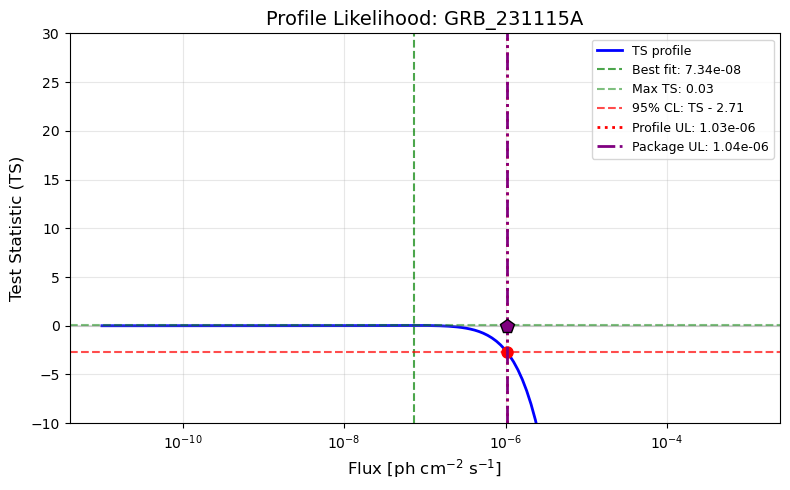


Analyzing GRB_180128A
[gtselect] time -p gtselect infile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_EV00.fits outfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_180128A/filtered.fits ra=11.888058 dec=-25.2888 rad=12.0 tmin=538809001.0 tmax=538810001.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=32 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_EV00.fits outfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_180128A/filtered.fits ra=11.888058 dec=-25.2888 rad=12.0 tmin=538809001.0 tmax=538810001.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=32 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no g

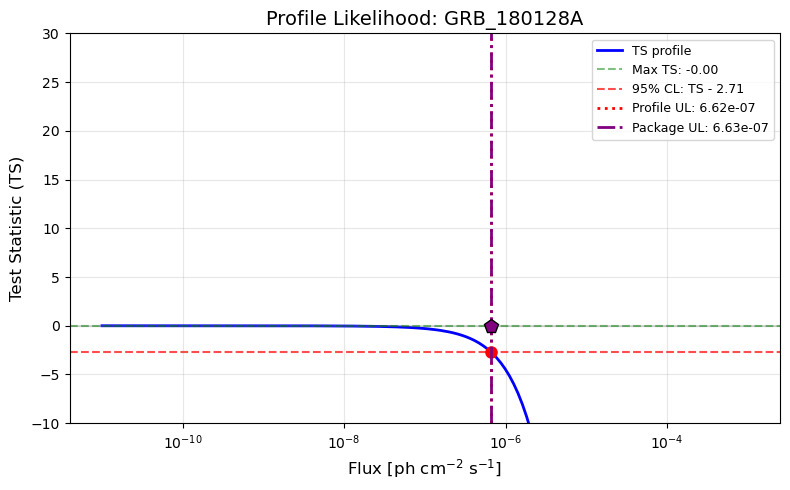


Analyzing GRB_120616A
[gtselect] time -p gtselect infile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_120616A/L250924145213039FD35840_EV00.fits outfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_120616A/filtered.fits ra=56.702142 dec=68.096106 rad=12.0 tmin=361552012.0 tmax=361553012.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=32 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_120616A/L250924145213039FD35840_EV00.fits outfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_120616A/filtered.fits ra=56.702142 dec=68.096106 rad=12.0 tmin=361552012.0 tmax=361553012.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=32 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no

Traceback (most recent call last):
  File "/var/folders/st/ng23bqyd59ndbk5_qmpyq8rr0000gn/T/ipykernel_80111/2696971516.py", line 95, in analyze_event
    ensure_nonempty_gti(gti_file)
  File "/var/folders/st/ng23bqyd59ndbk5_qmpyq8rr0000gn/T/ipykernel_80111/1041043558.py", line 39, in ensure_nonempty_gti
    raise RuntimeError("Empty GTI")
RuntimeError: Empty GTI


Done.
real 0.66
user 0.59
sys 0.07
  38 events selected
[gtmktime] time -p gtmktime scfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200423A/L250924145324039FD35856_SC00.fits sctable="SC_DATA" filter="(DATA_QUAL>0)&&(LAT_CONFIG==1)&&(IN_SAA==F)&&(LIVETIME>0)&&(ANGSEP(RA_ZENITH,DEC_ZENITH,308.718050,60.153678)<=88.0)" roicut=no evfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_200423A/filtered.fits evtable="EVENTS" outfile="/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_200423A/gti.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtmktime scfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200423A/L250924145324039FD35856_SC00.fits sctable="SC_DATA" filter="(DATA_QUAL>0)&&(LAT_CONFIG==1)&&(IN_SAA==F)&&(LIVETIME>0)&&(ANGSEP(RA_ZENITH,DEC_ZENITH,308.718

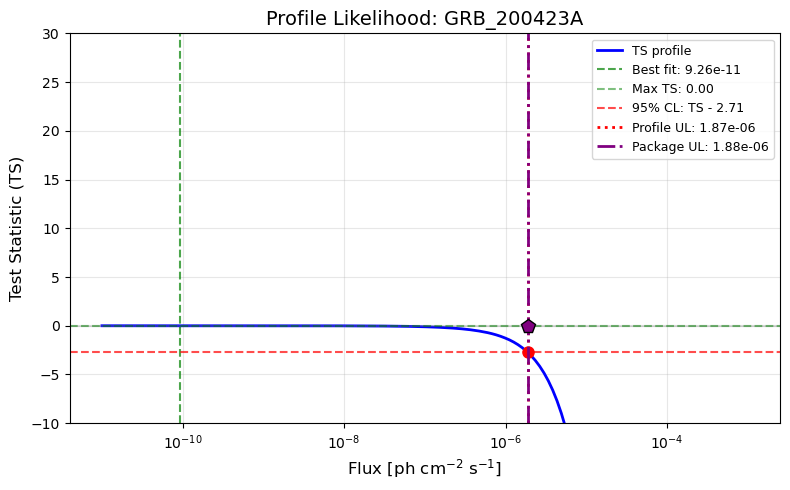


Analyzing GRB_231024A
[gtselect] time -p gtselect infile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231024A/L250924145416039FD35828_EV00.fits outfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231024A/filtered.fits ra=11.888058 dec=-25.2888 rad=12.0 tmin=719846439.0 tmax=719847439.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=32 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231024A/L250924145416039FD35828_EV00.fits outfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231024A/filtered.fits ra=11.888058 dec=-25.2888 rad=12.0 tmin=719846439.0 tmax=719847439.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=32 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no g

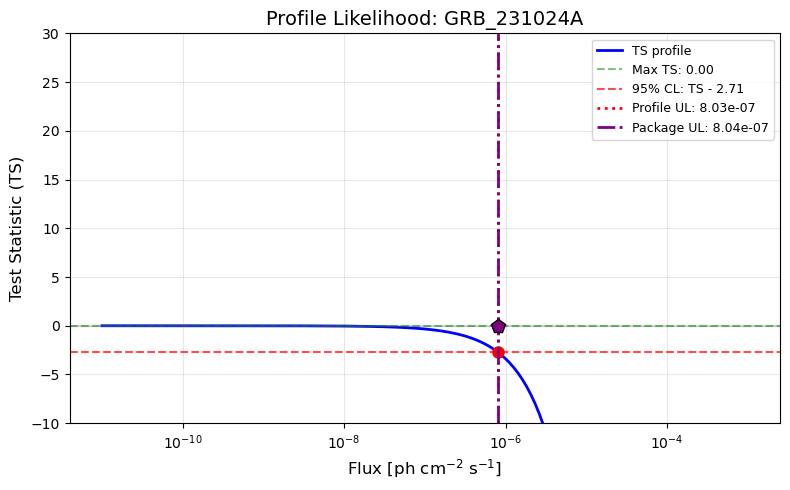


Analyzing GRB_081213A
[gtselect] time -p gtselect infile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_081213A/L251013184128F357373F31_EV00.fits outfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_081213A/filtered.fits ra=11.888058 dec=-25.2888 rad=12.0 tmin=250834182.0 tmax=250835182.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=32 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_081213A/L251013184128F357373F31_EV00.fits outfile=/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_081213A/filtered.fits ra=11.888058 dec=-25.2888 rad=12.0 tmin=250834182.0 tmax=250835182.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=32 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no g

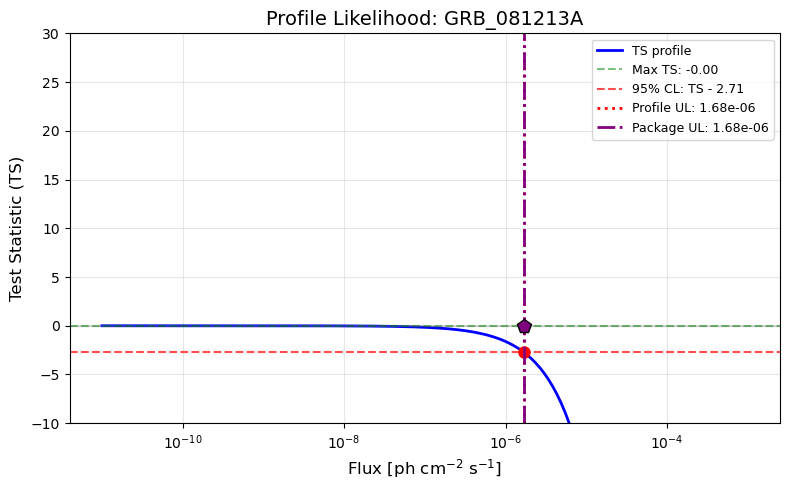


Successful analyses: 5/6

Stacking 5 profiles
  Stacked events: ['GRB_231115A', 'GRB_180128A', 'GRB_200423A', 'GRB_231024A', 'GRB_081213A']

Stacked Results:
  Maximum TS: -0.00
  Best fit flux: 2.38e-11 ph/cm²/s
  95% Upper Limit (stacked): 2.71e-07 ph/cm²/s


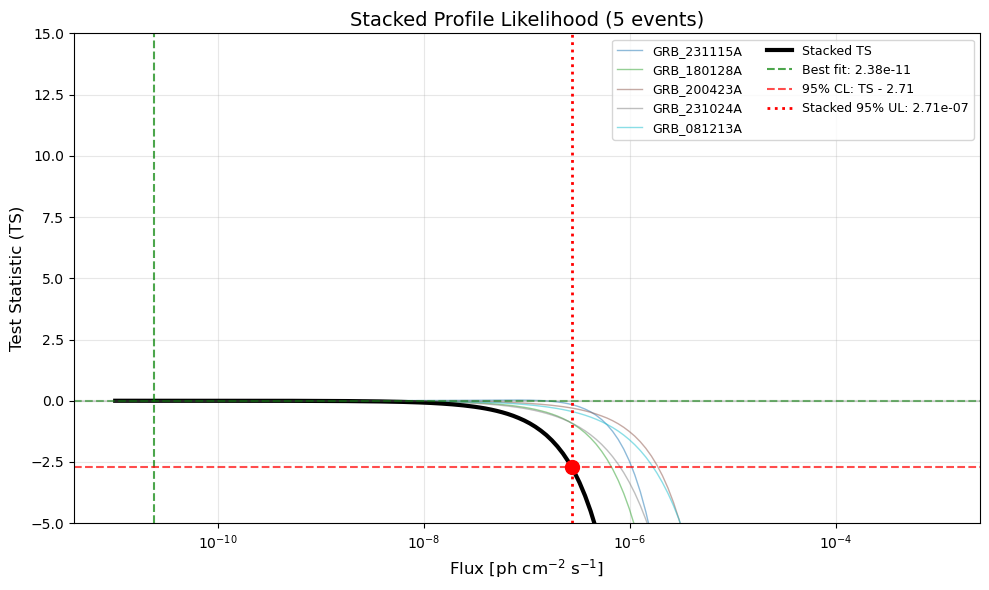


SUMMARY OF INDIVIDUAL UPPER LIMITS (Comparison of Two Methods)
Event             TS_max     Profile UL     Package UL    Ratio     Ontime   Status
----------------------------------------------------------------------------------------------------
GRB_231115A         0.03       1.03e-06       1.04e-06     0.99     1000.0       ok
GRB_180128A        -0.00       6.62e-07       6.63e-07     1.00      852.4       ok
GRB_120616A          N/A            N/A            N/A      ---        N/A   failed
GRB_200423A         0.00       1.87e-06       1.88e-06     1.00      381.4       ok
GRB_231024A         0.00       8.03e-07       8.04e-07     1.00     1000.0       ok
GRB_081213A        -0.00       1.68e-06       1.68e-06     1.00      282.1       ok
----------------------------------------------------------------------------------------------------

STACKED            -0.00       2.71e-07            ---      ---        ---       ok

Legend:
  Profile UL  = 95% Upper Limit from Profile Likelih

,Event,TS_max,UL95_Profile_ph_cm2_s,UL95_Package_ph_cm2_s,Ratio,Ontime_s,Status
0,GRB_231115A,2.895359e-02,1.034242e-06,1.039814e-06,0.994641,1000.000000,ok
1,GRB_180128A,-1.060614e-04,6.620013e-07,6.632444e-07,0.998126,852.400000,ok
2,GRB_120616A,NaN,NaN,NaN,NaN,NaN,failed
3,GRB_200423A,3.720476e-04,1.871452e-06,1.875778e-06,0.997694,381.400000,ok
4,GRB_231024A,4.238227e-07,8.025311e-07,8.041850e-07,0.997943,1000.000000,ok
5,GRB_081213A,-2.285935e-05,1.676153e-06,1.679887e-06,0.997777,282.084302,ok
6,STACKED,-3.980349e-05,2.709084e-07,NaN,NaN,NaN,ok


In [15]:
# ============================================================================
# RUN THE ANALYSIS
# ============================================================================
# Exclude GRB_200415A since it's a detection (not an upper limit)
exclude = {"GRB_200415A"}

all_results, stacked_result, df_summary = main(
    exclude_events=exclude,
    plot_individual=True
)

# Display the summary DataFrame
print("\n")
display(df_summary)

---
## Notes

### Interpretation
- **Individual Upper Limits**: Each event's 95% CL upper limit assuming non-detection
- **Stacked Upper Limit**: Combined constraint from all non-detection events
- **TS_max**: Maximum test statistic; TS > 25 typically indicates detection (5σ)

### Flux Units
- All fluxes in ph cm⁻² s⁻¹ (photon flux, 0.1-100 GeV)
- To convert to energy flux, use the spectral index assumption (Γ = -2)

### Stacking Method
- Profile likelihoods are summed: TS_stacked = Σ TS_i
- Assumes common flux for all events (appropriate for same-distance sources)
